In [10]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# Notebook_imports should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files
from src.data.Generators import DataGenerator
import src.models.Loss_and_metrics as metr

# import external libs
import cv2
import pandas as pd


EXPERIMENT = 'temp/spacing_1_8/'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata
DATA_PATH_SAX = '/mnt/ssd/data/acdc/2D/all/'
DF_FOLDS = '/mnt/ssd/data/acdc/2D/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 100

DIM = [128, 128] # network input shape for spacing of 3, (z,y,x)
SPACING = [1.8, 1.8] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 4 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
POLY_LR_DECAY = False
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_MIN = 0.3 # lower dropout at the shallow layers
DROPOUT_MAX = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8 # will be randomely applied to 80% of the files with a random other histogram
SHUFFLE = True
RESAMPLE = True
HIST_MATCHING = False
SCALER = 'MinMax' # MinMax, Standard or Robust

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]

LOSS_FUNCTION = metr.bce_dice_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

2021-04-16 08:24:56,182 INFO -------------------- Start --------------------
2021-04-16 08:24:56,182 INFO Working directory: /mnt/ssd/git/wft21_septum_landmark_detection.
2021-04-16 08:24:56,182 INFO Log file: ./logs/temp/spacing_1_8/.log
2021-04-16 08:24:56,183 INFO Log level for console: INFO


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/wft21_septum_landmark_detection
['/gpu:0', '/gpu:1']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2021-04-16 08:24:56,185 INFO Is built with tensorflow: True
2021-04-16 08:24:56,186 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-04-16 08:24:56,190 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10470783619616111245
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 443192290684365535
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12886412935279831138
physical_device_desc:

{'TSNE': active pyforest.LazyImport of <class 'sklearn.manifold._t_sne.TSNE'>, '__K': <module 'tensorflow.keras.backend' from '/home/sven/anaconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/keras/backend/__init__.py'>, 'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/spacing_1_8/', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/temp/spacing_1_8/2021-04-16_08_24', 'MODEL_PATH': 'exp/temp/spacing_1_8/2021-04-16_08_24/model', 'TENSORBOARD_PATH': 'exp/temp/spacing_1_8/2021-04-16_08_24/tensorboard_logs', 'CONFIG_PATH': 'exp/temp/spacing_1_8/2021-04-16_08_24/config', 'HISTORY_PATH': 'exp/temp/spacing_1_8/2021-04-16_08_24/history', 'DATA_PATH_SAX': '/mnt/ssd/data/acdc/2D/all/', 'DF_FOLDS': '/mnt/ssd/data/acdc/2D/df_kfold.csv', 'DF_META': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase', 'FOLD': 0, 'BATCHSIZE': 8, 'GENERATOR_WORKER': 8, 'EPOCHS': 100, 'DIM': [128, 128], 'SPACING': [1.8, 1.8], 'DEPTH': 4, 'FILTERS': 32, 'M_POOL': [2, 2], 'F

# Datagenerators

In [11]:
# Load SAX volumes
x_train, y_train, x_val, y_val =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train), len(y_train)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val), len(y_val)))

# create a batch generator
batch_generator = DataGenerator(x_train, y_train, config=config)
val_config = config.copy()
val_config['AUGMENT_GRID'] = False# make sure no augmentation will be applied to the validation data
val_config['AUGMENT'] = False
val_config['HIST_MATCHING'] = False
validation_generator = DataGenerator(x_val, y_val , config=val_config)

2021-04-16 08:24:56,959 INFO Found 1902 images/masks in /mnt/ssd/data/acdc/2D/all/
2021-04-16 08:24:56,959 INFO Patients train: 75
2021-04-16 08:24:57,022 INFO Selected 1426 of 1902 files with 75 of 100 patients for training fold 0
2021-04-16 08:24:57,023 INFO SAX train CMR: 1426, SAX train masks: 1426
2021-04-16 08:24:57,023 INFO SAX val CMR: 476, SAX val masks: 476
2021-04-16 08:24:57,024 INFO Create DataGenerator
2021-04-16 08:24:57,032 INFO Datagenerator created with: 
 shape: [128, 128]
 spacing: [1.8, 1.8]
 batchsize: 8
 Scaler: MinMax
 Images: 1426 
 Augment: True 
 Thread workers: 8
2021-04-16 08:24:57,033 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-04-16 08:24:57,033 INFO Create DataGenerator
2021-04-16 08:24:57,037 INFO Datagenerator created with: 
 shape: [128, 128]
 spacing: [1.8, 1.8]
 batchsize: 8
 Scaler: MinMax
 Images: 476 
 Augment: False 
 Thread workers: 8
2021-04-16 08:24:57,037 INFO No augmentation


## Visualize one batch

In [12]:
@interact
def select_image_in_batch(batch = (0,len(batch_generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    global x, y
    x, y = batch_generator.__getitem__(batch)
    info('selected batch : ' + str(batch))
    # logging level == debug --> visualise the generator steps
    info('X shape: {}, Y shape: {}'.format(x.shape, y.shape))
    show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
    plt.show()
    
    plt.hist(x[im].flatten())
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))

interactive(children=(IntSlider(value=89, description='batch', max=178), IntSlider(value=3, description='im', …

# Load an existing config/model

In [13]:
# Load a previous config and by this a pre-trained model
from ipyfilechooser import FileChooser
config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs'), 'config.json')
display(config_chooser)

FileChooser(path='/mnt/ssd/git/wft21_septum_landmark_detection/reports/configs', filename='config.json', title…

In [14]:
@interact
def interact_load_pretrained_model(config_file=glob.glob('reports/configs/{}/acdc/finetune/**/*.json'.format(config.get('ARCHITECTURE', '2D')), recursive=False), load=False):
    """
    load past config for model training 
    """
    # load config with all params into global namespace
    from src.models.ModelUtils import load_pretrained_model
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config_temp = json.loads(data_file.read())
        config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
        logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
        #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    
        try:
            # Cell for automation of the model loading process
            # load one basemodel for the finetuning task
            # load model
            globals()['model'] = load_pretrained_model(config_temp, metrics)
            model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=(), value=None), Checkbox(value=False, descr…

## Create Model

In [15]:
"""
load past config for model training 
"""
if 'streategy' in locals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))

import src.models.Unets as modelmanager
with strategy.scope():
    # create new model
    logging.info('Create model')
    model = modelmanager.create_unet(config, metrics, supervision=False)
    model.summary()

2021-04-16 08:25:02,188 INFO Create model


(None, 128, 128, 1)
Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128, 128, 32) 128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 128, 128, 32) 0           batch_normalization_10[0][0]     
___________________________________________________________________________

In [7]:
# test if all batches are processable
"""for b in range(len(batch_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)"""

'for b in range(len(batch_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)'

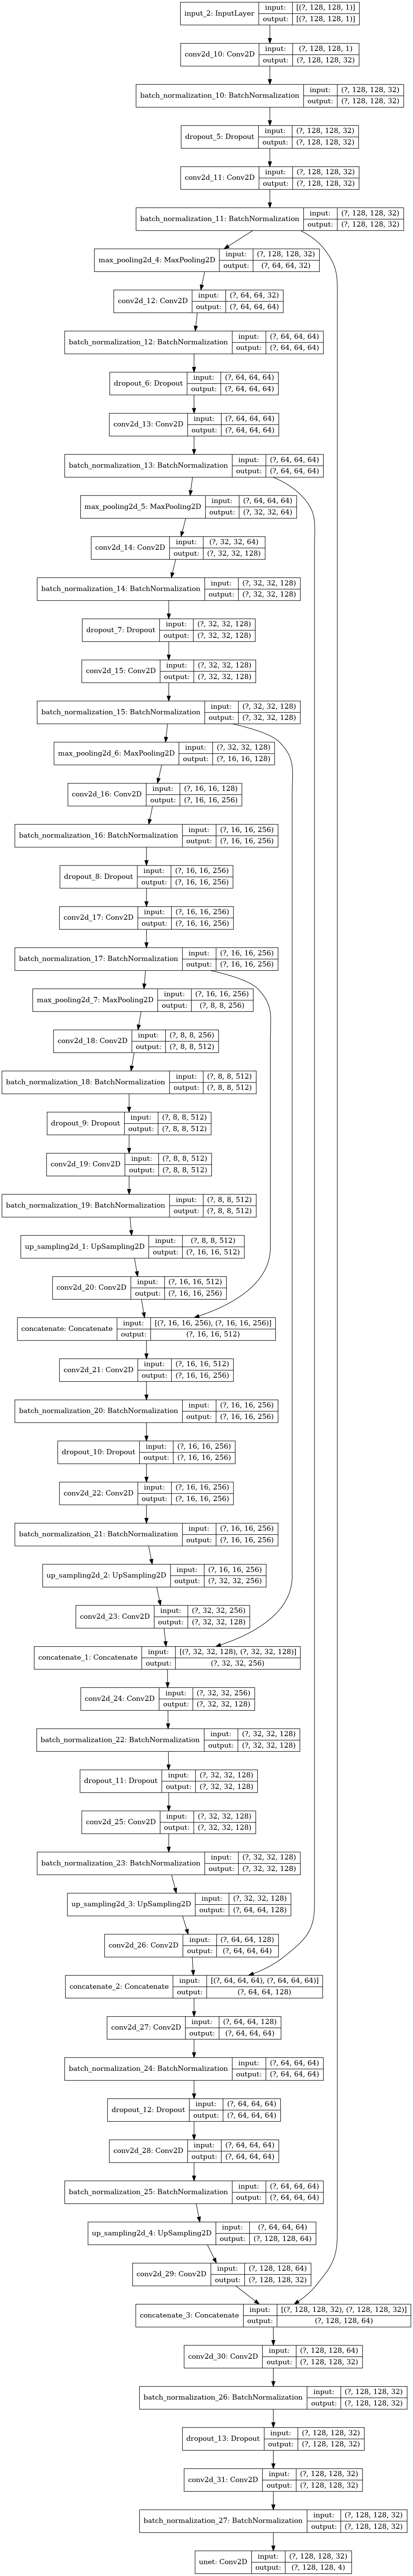

In [16]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
#model.summary(line_length=150)

In [17]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    verbose=1)

2021-04-16 08:25:19,391 INFO feed 4 Tensorboard is ready


Epoch 1/100
177/178 [============================>.] - ETA: 0s - loss: 0.2843 - dice_coef_labels: 0.0832 - dice_coef_myo: 0.0832 - dice_coef_lv: 0.0905 - dice_coef_rv: 0.0756
Epoch 00001: loss improved from inf to 0.28395, saving model to exp/temp/spacing_1_8/2021-04-16_08_24/model/model.h5
178/178 [==============================] - 7s 41ms/step - loss: 0.2839 - dice_coef_labels: 0.0833 - dice_coef_myo: 0.0833 - dice_coef_lv: 0.0906 - dice_coef_rv: 0.0757 - val_loss: 0.2007 - val_dice_coef_labels: 0.0560 - val_dice_coef_myo: 0.0513 - val_dice_coef_lv: 0.0482 - val_dice_coef_rv: 0.0663 - lr: 1.0000e-04
Epoch 2/100
177/178 [============================>.] - ETA: 0s - loss: 0.1941 - dice_coef_labels: 0.1096 - dice_coef_myo: 0.1065 - dice_coef_lv: 0.1190 - dice_coef_rv: 0.1033
Epoch 00002: loss improved from 0.28395 to 0.19438, saving model to exp/temp/spacing_1_8/2021-04-16_08_24/model/model.h5
178/178 [==============================] - 11s 64ms/step - loss: 0.1944 - dice_coef_labels: 0.1

KeyboardInterrupt: 

In [ ]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [10]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

# Slice the volumes by the gt onehot, later with the pred onehot, which has the same shape

In [81]:
@interact_manual
def get_phase_vol(batch = (0, inputs.shape[0])):
    global inputs, outputs
    inputs = tf.convert_to_tensor(inputs)
    outputs = tf.convert_to_tensor(outputs)
    print('target shape: {}'.format(outputs.shape))
    print('inputs shape: {}'.format(inputs.shape))
    gt, msk = tf.unstack(outputs, axis=1)
    print(gt.shape)
    print(msk.shape)
    gt_masked = gt * msk
    idxs = tf.math.argmax(gt_masked, axis=1)
    print('Indicies shape: {}'.format(idxs.shape))

    # slice the five timesteps from all batches
    # we need to fill the dimensions from behind by [...,tf.newaxis]
    # and define the number of leading batch dimensions
    t_all_in = tf.gather_nd(inputs, idxs[...,tf.newaxis], batch_dims=1)
    print(t_all_in.shape)

    _ = list(map(lambda x : show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)),  t_all_in[batch]))

interactive(children=(IntSlider(value=4, description='batch', max=8), Button(description='Run Interact', style…

In [77]:
temp = np.random.random((10,10,10))
print(temp.shape)
_ = list(map(lambda x: list(map(lambda y: print(y.shape), x)), temp))

(10, 10, 10)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)


one patient input: (36, 8, 64, 64, 1)
one patient idx: (5,)
t1: 3


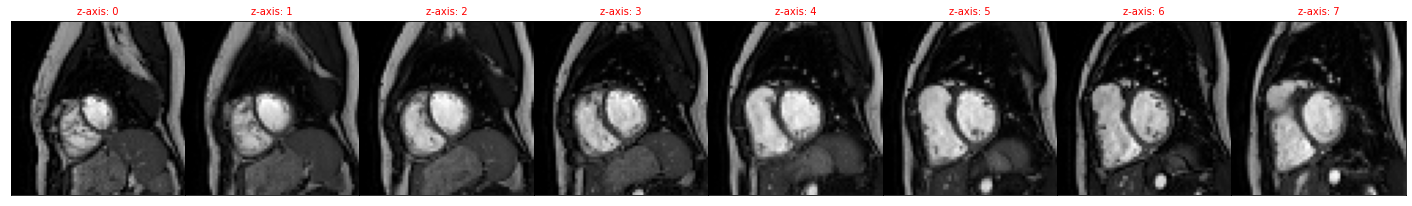

(5, 8, 64, 64, 1)


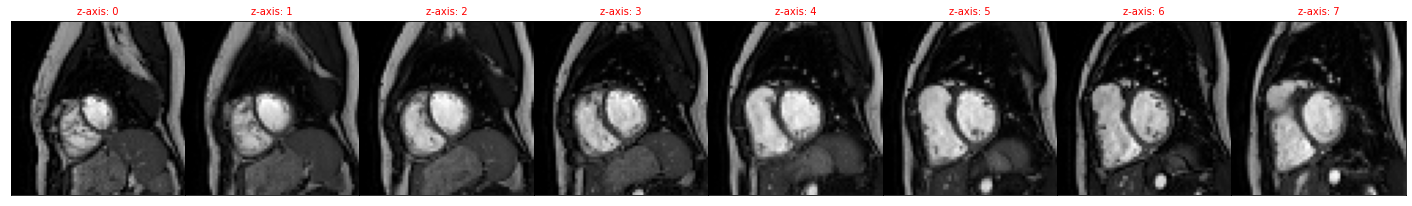

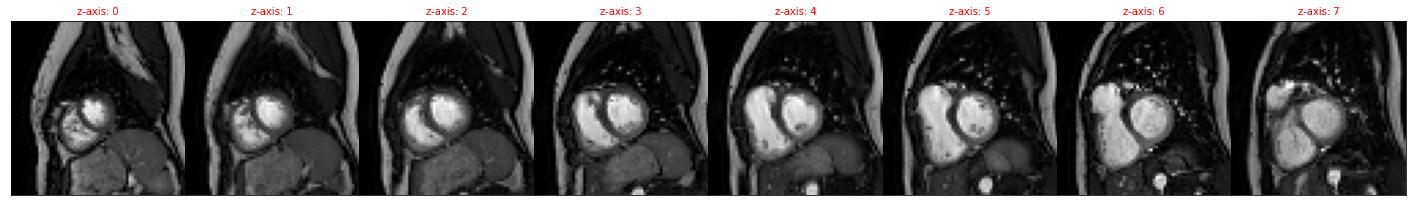

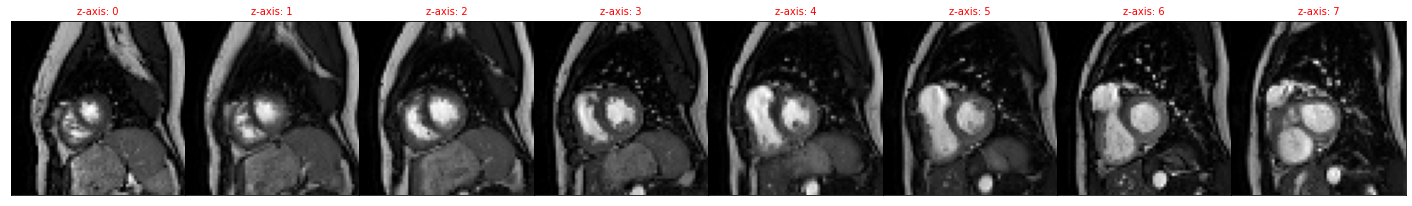

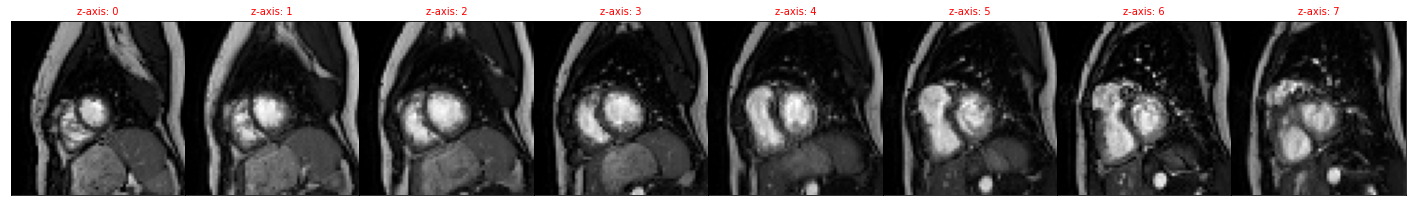

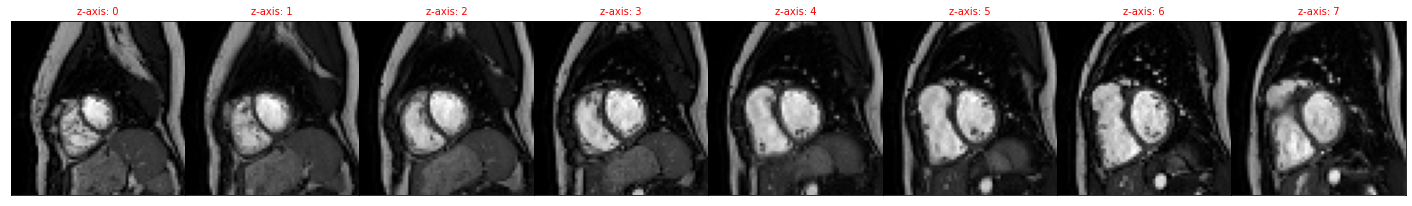

In [50]:
# slice of one patient
temp_in = inputs[0]
print('one patient input: {}'.format(temp_in.shape))
temp_idx = tf.cast(idxs[0], dtype = tf.int32)
print('one patient idx: {}'.format(temp_idx.shape))

# manually slice one timetep, as visual comparison
t1 = temp_idx[0]
print('t1: {}'.format(t1))
t1_in = temp_in[t1]
show_2D_or_3D(img=t1_in, interpol='bilinear',dpi=100,f_size=(5,5)); plt.show()

# slice ll 5 timeteps
t_all_in = tf.gather(temp_in, temp_idx)
print(t_all_in.shape)
_ = list(map(lambda x : show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), t_all_in ))

In [27]:
tf.squeeze(temp_idx)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 3,  8, 13, 16, 23])>

In [10]:
# get the true idx
temp = 
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[[1 1 1 1 1]
  [1 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 ...

 [[1 1 1 1 0]
  [0 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 0 1]
  [1 1 1 0 0]
  [0 1 1 1 0]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


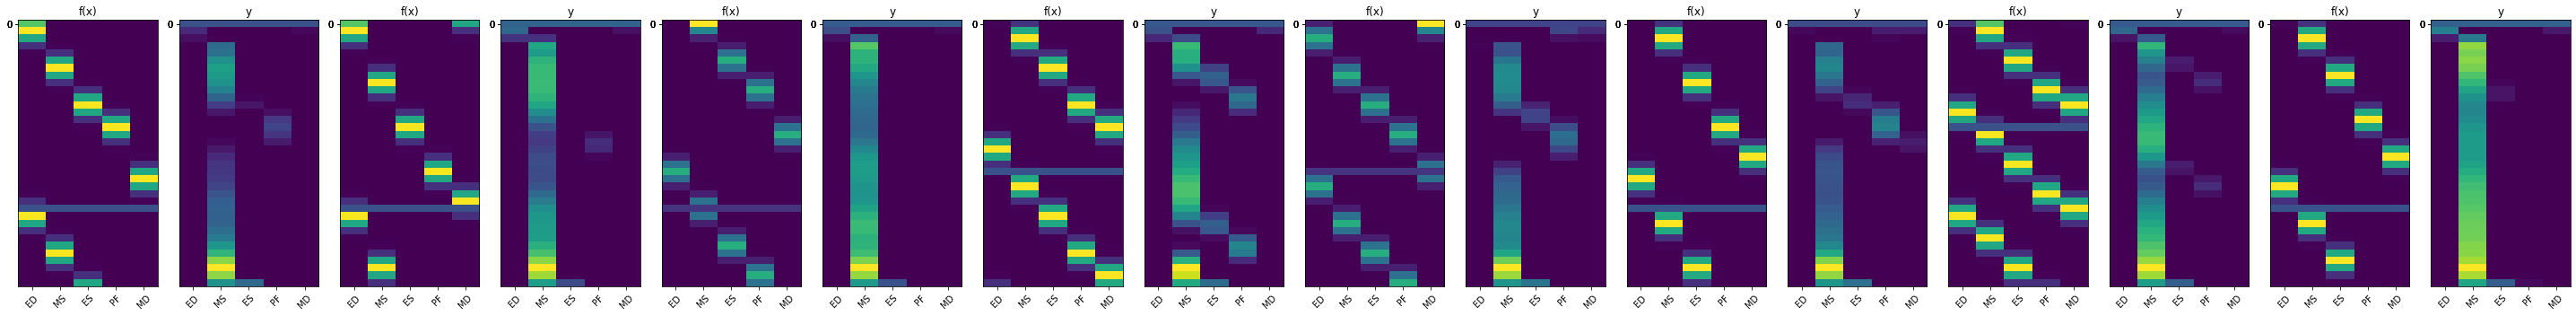

In [23]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases(pred,outputs)

In [25]:
pred.shape

TensorShape([8, 2, 36, 5])

In [14]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

24.776663

In [14]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

NameError: name 'outputs' is not defined

In [15]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

ModuleNotFoundError: No module named 'src.utils.Metrics'

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

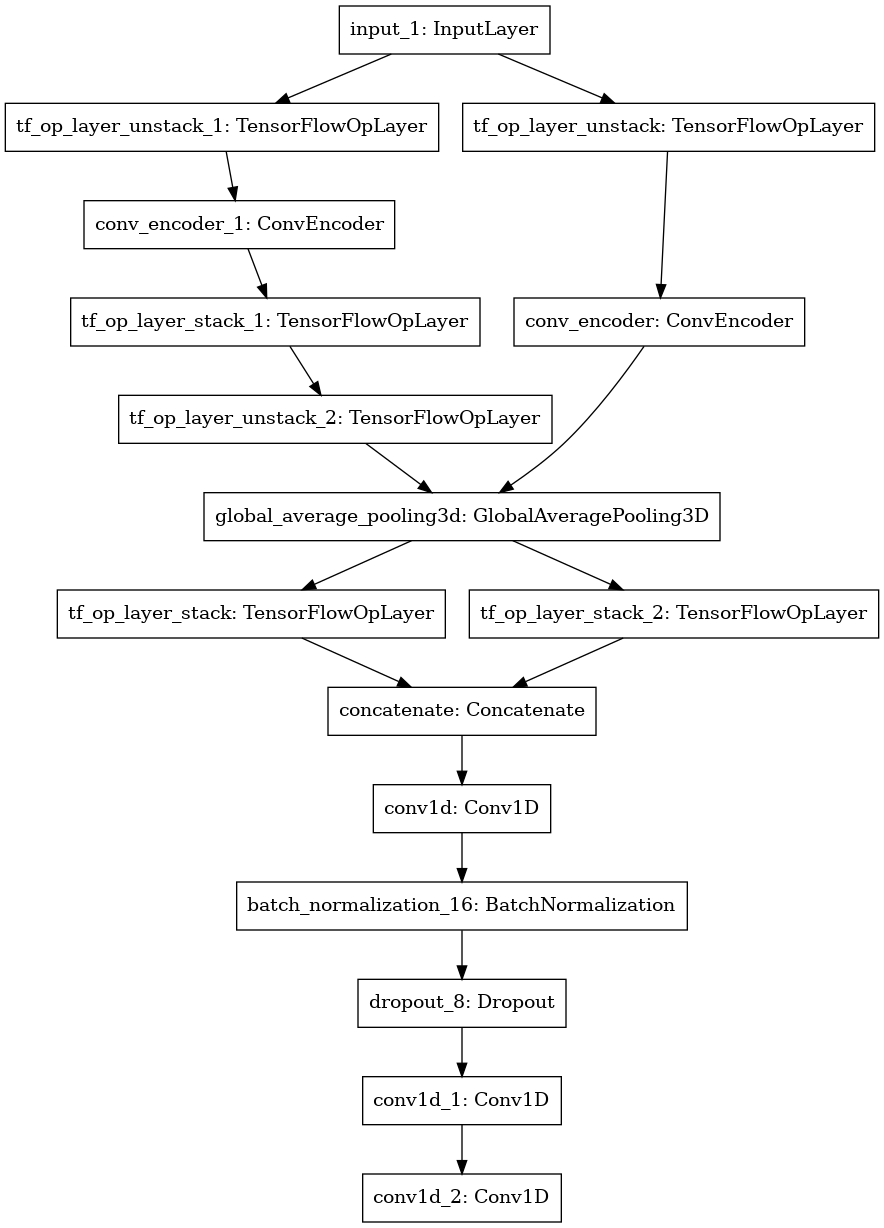

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)